In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import distance_matrix
import random

In [ ]:
def generate_imbalanced_data(num_minority=15, num_majority=40):
    minority_data = np.random.uniform(-2, 0.5, (num_minority, 1))
    majority_data = np.random.uniform(-0.5, 2, (num_majority, 1))
    minority_labels = np.zeros((num_minority, 1))
    majority_labels = np.ones((num_majority, 1))
    data = np.vstack((minority_data, majority_data))
    labels = np.vstack((minority_labels, majority_labels))
    return data, labels

In [ ]:
data, labels = generate_imbalanced_data()

In [ ]:
labels

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
P = data[labels == 0]
N = data[labels == 1]

In [ ]:
def sample_size(N, num_min):
    p = num_min / N
    if p == 0 and N >= 9:
        size1 = 0
    elif p == 0 or p == 1:
        size1 = 1
    else:
        Z = 1.64
        epsilon = 0.05
        e = epsilon + np.log(N) / N
        x = (Z**2 * p * (1-p)) / (e**2)
        size1 = (N * x) / (x + N - 1)
    return math.ceil(size1)

In [ ]:
num_min = len(P)
num_N = len(N)
calculated_sample_size = sample_size(num_N, num_min)

In [ ]:
calculated_sample_size

18

In [ ]:
def calculate_weights(data, labels, k=5):
    labels = labels.flatten()
    n_samples = len(data)
    weights = np.zeros(n_samples)
    distances = distance_matrix(data, data)

    for i in range(n_samples):
        sorted_indices = np.argsort(distances[i])
        sorted_indices = sorted_indices[sorted_indices != i]  # Robustly exclude self
        nearest_indices = sorted_indices[:k]

        inverse_distances = 1 / (distances[i, nearest_indices] + 1e-5)  # Prevent division by zero

        # Mask for same-class and different-class neighbors
        same_class_mask = (labels[nearest_indices] == labels[i])
        different_class_mask = ~same_class_mask

        # Weights for same and different class
        same_class_weights = inverse_distances * same_class_mask
        different_class_weights = inverse_distances * different_class_mask

        # Compute a complexity score
        total_same_class_weight = np.sum(same_class_weights)
        total_different_class_weight = np.sum(different_class_weights)

        total_weight = total_same_class_weight + total_different_class_weight
        if total_weight > 0:
            complexity_score = total_same_class_weight / total_weight
        else:
            complexity_score = 0  # No influential neighbors

        weights[i] = complexity_score

    return weights




weights = calculate_weights(data, labels, k=5)
minority_weights = weights[labels.flatten() == 0]
majority_weights = weights[labels.flatten() == 1]


In [ ]:
majority_weights

array([1.        , 1.        , 0.90164417, 1.        , 1.        ,
       1.        , 1.        , 0.92419946, 0.20846688, 1.        ,
       0.92364097, 1.        , 1.        , 0.61975209, 1.        ,
       0.28921299, 0.91809123, 1.        , 1.        , 1.        ,
       1.        , 0.8860927 , 0.97148012, 0.68697407, 0.60394819,
       1.        , 0.69915186, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.92693334, 0.08524861, 1.        , 0.73511803, 0.55877446])

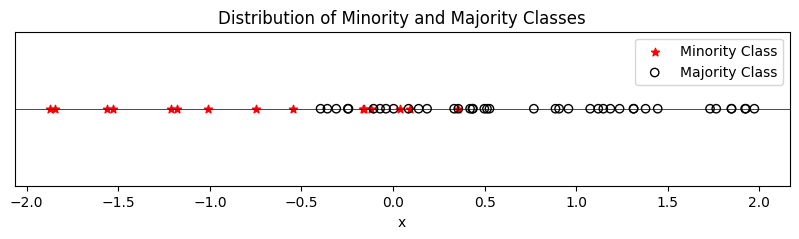

In [ ]:
# Plot the results
plt.figure(figsize=(10, 2))
plt.scatter(P, np.zeros_like(P), color='red', marker='*', label='Minority Class')
plt.scatter(N, np.zeros_like(N), edgecolor='black', facecolor='none', label='Majority Class')
plt.title('Distribution of Minority and Majority Classes')
plt.xlabel('x')
plt.yticks([])  # Remove y-axis ticks
plt.ylim(-1, 1)  # Set y-axis limits to provide some space around the points
plt.axhline(0, color='black', linewidth=0.5)  # Draw x-axis line
plt.legend()
plt.grid(False)  # Remove grid lines
plt.savefig('fig1.png', dpi=300)
plt.show()


In [ ]:
minority_complexity = sum(minority_weights)/len(minority_weights)
majority_complexity = sum(majority_weights)/len(majority_weights)
print(f"Minority Class Complexity: {minority_complexity:.4f}")
print(f"Majority Class Complexity: {majority_complexity:.4f}")


Minority Class Complexity: 0.6796
Majority Class Complexity: 0.8735


In [ ]:
def initialize_population(weights, N, max_P, subset_size, population_size):
    valid_indices = np.where(N > max_P)[0]
    return [np.random.choice(valid_indices, size=subset_size, replace=False) for _ in range(population_size)]

def fitness(individual, weights):
    return np.sum(weights[individual])

def select_parents(population, fitness_scores, num_parents):
    parents = random.choices(population, weights=fitness_scores, k=num_parents)
    return parents

def crossover(parent1, parent2, subset_size):
    combined = np.concatenate((parent1, parent2))
    np.random.shuffle(combined)
    child = np.unique(combined)[:subset_size]
    while len(child) < subset_size:
        additional = np.random.choice(parent1, size=(subset_size - len(child)), replace=False)
        child = np.unique(np.concatenate((child, additional)))[:subset_size]
    return child

def mutate(individual, mutation_rate, valid_indices):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            replacement = np.random.choice([idx for idx in valid_indices if idx not in individual])
            individual[i] = replacement
    return individual


def genetic_algorithm(N, weights, max_P, population_size, subset_size, generations, mutation_rate):
    valid_indices = np.where(N > max_P)[0]
    population = initialize_population(weights, N, max_P, subset_size, population_size)
    best_solution = None
    best_fitness = -np.inf

    for _ in range(generations):
        fitness_scores = [fitness(ind, weights) for ind in population]

        for ind, fit in zip(population, fitness_scores):
            if fit > best_fitness:
                best_fitness = fit
                best_solution = ind

        parents = select_parents(population, fitness_scores, population_size)
        children = [mutate(crossover(parents[i], parents[(i+1) % len(parents)], subset_size), mutation_rate, valid_indices) for i in range(len(parents))]

        population = children

    return N[best_solution], best_fitness

In [ ]:
population_size = 50
subset_size = sample_size
generations = 100
mutation_rate = 0.01
max_P = max(P)
best_subset, best_fitness = genetic_algorithm(N, weights, max(P), 50, calculated_sample_size, 100, 0.01)  # Adjust parameters as needed
print("Best Subset of N based on Weights:", best_subset)

Best Subset of N based on Weights: [1.73099082 1.23715848 1.148246   1.92265628 0.90685912 1.76483677
 0.43644351 1.92652202 1.8486736  0.42078048 1.97307595 0.88703251
 1.31391103 0.49841941 0.43341323 0.35645298 1.44527011 1.07652724]


In [ ]:
def concatenate_samples(P, N, SetN):
    P = P.reshape(-1, 1) if P.ndim == 1 else P
    N = N.reshape(-1, 1) if N.ndim == 1 else N
    SetN = SetN.reshape(-1, 1) if SetN.ndim == 1 else SetN

    P_cartesian = np.array([np.concatenate([p1, p2]) for p1 in P for p2 in P])

    N_cartesian = np.array([np.concatenate([n, sn]) for n in N for sn in SetN])

    return P_cartesian, N_cartesian

In [ ]:
P_cartesian, N_cartesian = concatenate_samples(P, N, best_subset)
new_weights = calculate_weights(np.vstack((P_cartesian, N_cartesian)), np.concatenate([np.zeros(len(P_cartesian)), np.ones(len(N_cartesian))]), k=5)

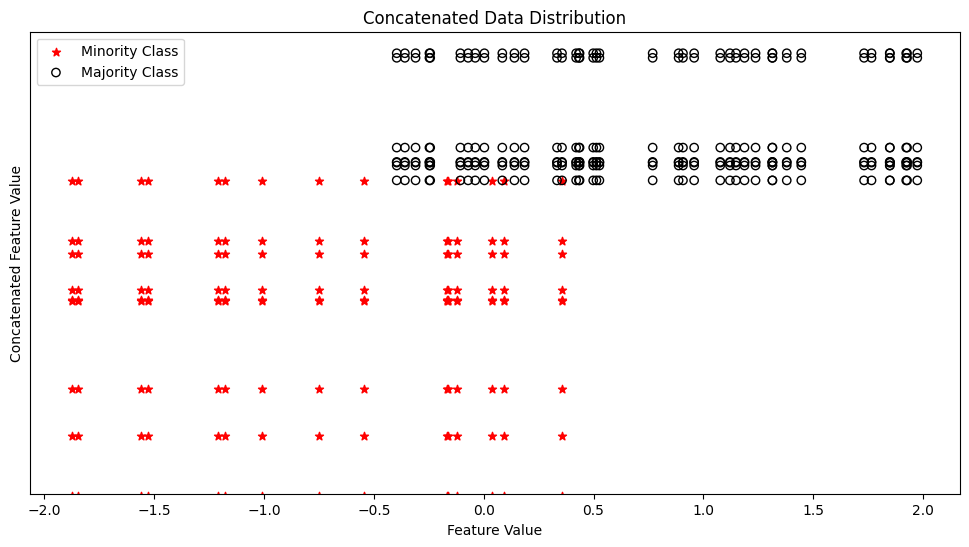

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(P_cartesian[:, 0], P_cartesian[:, 1], color='red', marker='*', label='Minority Class' )
plt.scatter(N_cartesian[:, 0], N_cartesian[:, 1], edgecolor='black', facecolor='none', label='Majority Class')
plt.title('Concatenated Data Distribution')
plt.xlabel('Feature Value')
plt.ylabel('Concatenated Feature Value')
plt.yticks([])  # Remove y-axis ticks
plt.ylim(-1, 1)  # Set y-axis limits to provide some space around the points

plt.legend()
plt.grid(False)  # Remove grid lines
plt.savefig('fig2.png', dpi=300)
plt.show()

In [ ]:
N_cartesian.shape

(720, 2)

In [ ]:
minority_weights_new = new_weights[:len(P_cartesian)]
majority_weights_new = new_weights[len(P_cartesian):]
minority_complexity_new = np.sum(minority_weights_new) / len(minority_weights_new)
majority_complexity_new = np.sum(majority_weights_new) / len(majority_weights_new)
print(f"New Minority Class Complexity: {minority_complexity_new:.4f}")
print(f"New Majority Class Complexity: {majority_complexity_new:.4f}")


New Minority Class Complexity: 0.9791
New Majority Class Complexity: 0.9951
